In [6]:
# Create folder structure
import os

folders = [
    "data/prices",
    "data/fundamentals",
    "features",
    "models",
    "scripts"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

# Install required libraries
!pip install yfinance lightgbm pandas scikit-learn


In [7]:
import yfinance as yf
import pandas as pd

# List of tickers to download (example: Apple, Microsoft, Google)
tickers = ["AAPL", "MSFT", "GOOGL"]

def download_price_data(tickers, folder="data/prices"):
    for ticker in tickers:
        print(f"Downloading {ticker} data...")
        data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
        data.to_csv(f"{folder}/{ticker}.csv")
    print("Download complete.")

download_price_data(tickers)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Download complete.


In [9]:
import pandas as pd
import glob

for file in glob.glob("data/prices/*.csv"):
    df = pd.read_csv(file)
    print(f"Columns in {file}: {df.columns.tolist()}")


Columns in data/prices/MSFT.csv: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Columns in data/prices/GOOGL.csv: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Columns in data/prices/AAPL.csv: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']


In [11]:
import pandas as pd
import glob

for file in glob.glob("data/prices/*.csv"):
    df = pd.read_csv(file)
    print(f"Columns in {file}: {df.columns.tolist()}")


Columns in data/prices/MSFT.csv: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Columns in data/prices/GOOGL.csv: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
Columns in data/prices/AAPL.csv: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']


In [13]:
df[price_col] = pd.to_numeric(df[price_col], errors='coerce')


In [14]:
df['return'] = df[price_col].pct_change(fill_method=None)


In [15]:
import pandas as pd
import glob

def engineer_features(input_folder="data/prices", output_file="features/engineered_features.csv"):
    all_features = []

    def get_price_column(df):
        for col in ['Adj Close', 'Adj Close*', 'Close']:
            if col in df.columns:
                return col
        raise ValueError("No suitable price column found")

    for file in glob.glob(f"{input_folder}/*.csv"):
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        ticker = file.split("/")[-1].replace(".csv", "")
        price_col = get_price_column(df)

        # Convert price column to numeric
        df[price_col] = pd.to_numeric(df[price_col], errors='coerce')

        df['return'] = df[price_col].pct_change(fill_method=None)
        df['ma5'] = df[price_col].rolling(window=5).mean()
        df['ma10'] = df[price_col].rolling(window=10).mean()
        df['target'] = df['return'].shift(-1)  # next day return as target
        df['ticker'] = ticker

        df.dropna(inplace=True)
        all_features.append(df)

    result = pd.concat(all_features)
    result.to_csv(output_file)
    print(f"Features saved to {output_file}")

engineer_features()


Features saved to features/engineered_features.csv


<ipython-input-15-5b88ebefee91>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True)
<ipython-input-15-5b88ebefee91>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True)
<ipython-input-15-5b88ebefee91>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file, index_col=0, parse_dates=True)


In [16]:
import pandas as pd

# Load the engineered features CSV
df_features = pd.read_csv("features/engineered_features.csv", index_col=0)

print(df_features.head())


                Close       High        Low       Open    Volume    return  \
Price                                                                        
2018-01-16  81.543648  83.795676  81.229844  83.158830  36599700 -0.013951   
2018-01-17  83.195732  83.324946  81.912816  82.217395  25621200  0.020260   
2018-01-18  83.158813  83.684901  82.752715  82.881929  24159700 -0.000444   
2018-01-19  83.066528  83.629535  82.752725  83.195742  36875000 -0.001110   
2018-01-22  84.552498  84.561729  82.826557  83.066529  23601600  0.017889   

                  ma5       ma10    target ticker  
Price                                              
2018-01-16  81.602711  81.031396  0.020260   MSFT  
2018-01-17  81.957129  81.418118 -0.000444   MSFT  
2018-01-18  82.377997  81.764227 -0.001110   MSFT  
2018-01-19  82.732416  82.030964  0.017889   MSFT  
2018-01-22  83.103444  82.346616  0.003165   MSFT  


In [17]:
from sklearn.model_selection import train_test_split

# Select feature columns and target column
feature_cols = ['return', 'ma5', 'ma10']
target_col = 'target'

X = df_features[feature_cols]
y = df_features[target_col]

# Split into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


Training samples: 3597, Testing samples: 900


In [37]:
import joblib
joblib.dump(model, 'models/lgbm_model.pkl')


['models/lgbm_model.pkl']

In [18]:
!pip install lightgbm


In [20]:
import lightgbm as lgb

# Create datasets for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# Parameters for regression
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1
}

# Train the model with early stopping via callback
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.0187788


In [23]:
from math import sqrt
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f"Test RMSE: {rmse:.5f}")


Test RMSE: 0.01878


In [29]:
import os

# List all files in the 'data/prices' directory
os.listdir('data/prices')


['MSFT.csv', 'GOOGL.csv', 'AAPL.csv']

In [30]:
import pandas as pd

# Load the CSV file into a DataFrame
new_data = pd.read_csv('data/prices/AAPL.csv', index_col=0, parse_dates=True)

# Display the first few rows to verify
new_data.head()


<ipython-input-30-acaf48fd4a08>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_data = pd.read_csv('data/prices/AAPL.csv', index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume
Price,,,,,
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,NaN,NaN,NaN,NaN,NaN
2018-01-02,40.426822662353516,40.436212064432425,39.72276790875693,39.9339864834405,102223600
2018-01-03,40.41978454589844,40.964255303118776,40.35642219303837,40.490190741195256,118071600
2018-01-04,40.60753631591797,40.71079826612631,40.3845863312453,40.49253940209357,89738400


In [31]:
# Define the price column
price_col = 'Adj Close' if 'Adj Close' in new_data.columns else 'Close'

# Ensure the price column is numeric
new_data[price_col] = pd.to_numeric(new_data[price_col], errors='coerce')

# Calculate returns and moving averages
new_data['return'] = new_data[price_col].pct_change()
new_data['ma5'] = new_data[price_col].rolling(window=5).mean()
new_data['ma10'] = new_data[price_col].rolling(window=10).mean()

# Drop rows with missing values
new_data.dropna(inplace=True)

# Select features for prediction
X_new = new_data[['return', 'ma5', 'ma10']]


In [33]:
import joblib

# Load the model
model = joblib.load('models/lgbm_model.pkl')


In [34]:
# Assuming you already loaded `new_data`
price_col = 'Adj Close' if 'Adj Close' in new_data.columns else 'Close'

# Convert price column to numeric
new_data[price_col] = pd.to_numeric(new_data[price_col], errors='coerce')

# Engineer features
new_data['return'] = new_data[price_col].pct_change()
new_data['ma5'] = new_data[price_col].rolling(window=5).mean()
new_data['ma10'] = new_data[price_col].rolling(window=10).mean()
new_data.dropna(inplace=True)

# Select the feature columns
X_new = new_data[['return', 'ma5', 'ma10']]


In [35]:
# Predict with the trained model
y_pred_new = model.predict(X_new)


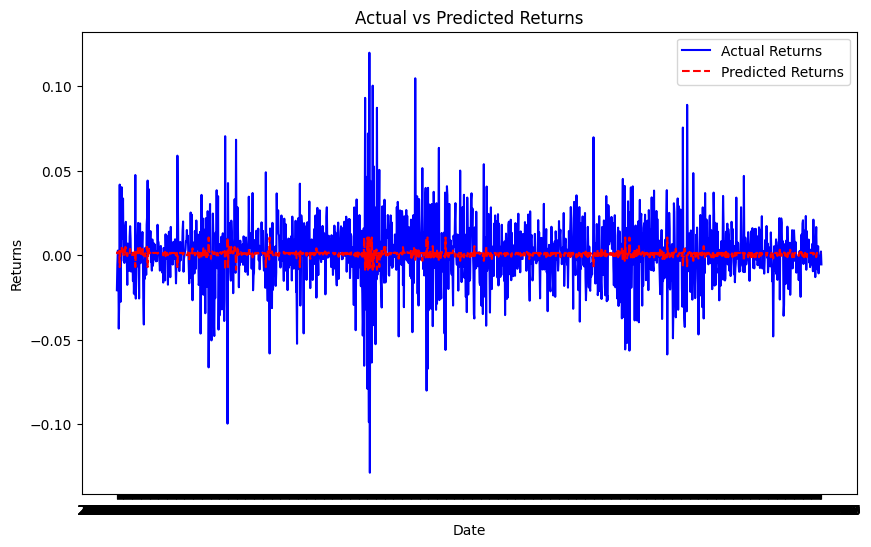

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(new_data.index, new_data['return'], label='Actual Returns', color='blue')
plt.plot(new_data.index, y_pred_new, label='Predicted Returns', color='red', linestyle='--')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()
